# HW0 - Warmup

In this assignment we will warmup our coding skills and have a short intro to machine learning mechanics.

Readings:
- AI creativity: https://towardsdatascience.com/supercreativity-b4114ebd0357
- Generative Models: https://openai.com/blog/generative-models/
- ML intro http://www.r2d3.us/visual-intro-to-machine-learning-part-1/
- NN activations: https://distill.pub/2019/activation-atlas/

We will see three cool tricks with neural networks that show their generative power:
- Style Transfer
- Deep Dream
- Neural Doodle

These are "old" tricks, but they can still teach us a whole lot about how neural networks work and what they can be used for. Some key concepts to look out for are: **Loss function, Gradient (descent), Activation, Layer**.

You are welcome to tweak parameters and see what results you get!
But it will be the best if you actually hack around and change input images...

BTW: All this code is free for you (and everyone) to use and share!

In [0]:
# There's some boilerplate code here below, run it (shift+Enter over each cell) ... Expand and take a peek if you'd like

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
from __future__ import absolute_import, division, print_function

import functools
import os
import time

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import clear_output

tf.enable_eager_execution()

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  1.14.0
TF-Hub version:  0.6.0
Eager mode enabled:  True
GPU available:  False


In [0]:
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images."""
    # Cache image file locally.
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
    # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
    img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...] / 255.
    if img.shape[-1] == 4:
        img = img[..., :3] / tf.expand_dims(img[..., 3], -1) # pre multiply alpha
        
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

def show_n(images, titles=('',), w=8, colorbar=False):
    n = len(images)
    plt.figure(figsize=(w * n, w))
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
        if colorbar:
            plt.colorbar()
    plt.show()

## Style Transfer

Style transfer is a neat implementation using deep convolutional networks to tranfer artistic style from one image to another.

Read in more depth: https://blog.paperspace.com/art-with-neural-networks/

Cool examples of style transfer: http://genekogan.com/works/style-transfer/

Let's load some images from the net:

In [0]:
content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg' 
output_image_size = 512 

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)

2686976/2684586 [==============================] - 0s 0us/step


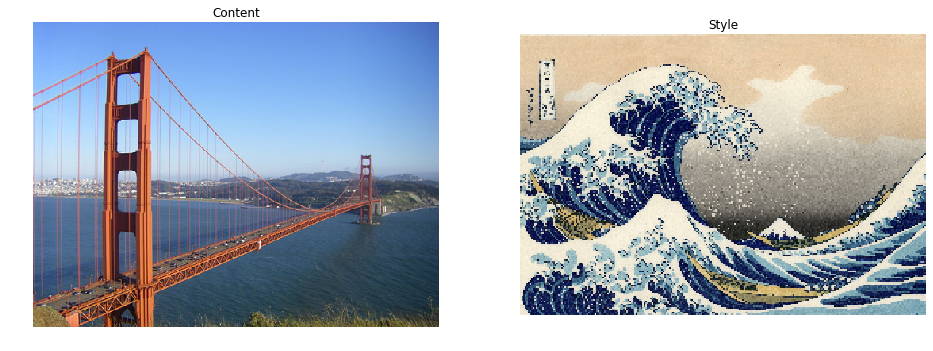

In [0]:
show_n([content_image, style_image], ['Content', 'Style'])

The goal is to apply the style of "Style Image" to "Content Image".

Tensorflow Hub is a collection of models pre-trained and ready to use.
We can find a style transfer model there too: https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1

In [0]:
# Load image stylization module.
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

Using it is very straightforward:

In [0]:
# Stylize image.
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

And the reults are cool!

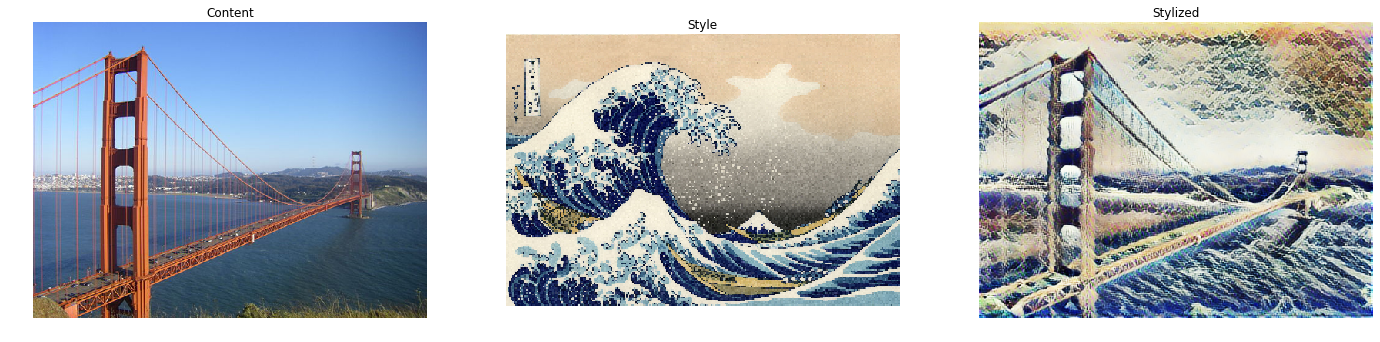

In [0]:
show_n([content_image, style_image, stylized_image], ['Content', 'Style', 'Stylized'])

What happens here under the hood is that we iteratively change the "Content Image" to follow the "Style Image" on "low visual layers". The deep convolutional neural network is divided to many layers (sometimes dozens and hundreds). Each layer successively learns more complex visual constructs. If we try to match just the lower layers - only the "painting style" will transfer.

## Deep Dream

This refers to the process of amplifying the "eye of the CNN". In other words, making the network hallucinate visual features (e.g. eyes, faces) it learnt from millions of images in plain images, where only hints of these structures exist.

This is a good example of using Gradient Ascent. It's an inverse optimization problem, where instead of trying to minimize the loss - we try to maximize it, amplify it.

This tutorial is based on: https://www.tensorflow.org/beta/tutorials/generative/deepdream

Let's see what the network finds in a Kandinsky:

In [0]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'

196608/195196 [==============================] - 0s 0us/step


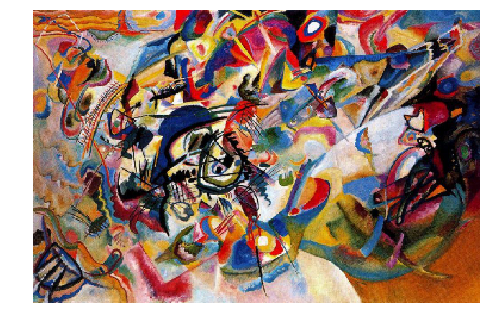

In [0]:
content_image = load_image(url, image_size=(375,375))
show_n([content_image])

Here we use the Inception network from Google. It was a winner of the ILSVRC circa 2013.

Read about it here if interested in knowing more: https://medium.com/coinmonks/paper-review-of-googlenet-inception-v1-winner-of-ilsvlc-2014-image-classification-c2b3565a64e7

In [0]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 4s 0us/step


We select a couple of layers from the network to maximize. These layers correspond to a size/level of visual construct. The lower layers will see very local visual features (lines, little blobs), while the higher ones will see e.g. eyes, faces, noses, etc.

In [0]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

The Loss function guides our inverse optimization. Here it is very simple, it's just looking to increase the activation in our selected layers. You can explore the activations of InceptionNet here: https://distill.pub/2019/activation-atlas/ See every layer and neuron group "like" a different concept like: Pineapple, Hot dog, Jeans and Sleeping bag...

In [0]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    layer_activations = model(img)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

Some code is obviously necessary to run the optimization... I'll spare you the details, but if you want to run this for youself you'd need to execute these cells.

In [0]:
@tf.function
def deepdream(model, img, step_size):
    print("deepdream",type(img),img.shape)
    with tf.GradientTape() as tape:
        # This needs gradients relative to `img`
        # `GradientTape` only watches `tf.Variable`s by default
        tape.watch(img)
        loss = calc_loss(img, model)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    
    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)

    return loss, img


In [0]:
def deprocess(img):
    img = 127.5*(img + 1.0)
    return tf.cast(img, tf.uint8)

In [0]:
def run_deep_dream_simple(model, img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    clear_output(wait=True)
    show_n([deprocess(img)])

    # main execution loop, every iteration applies little changes to the image
    for step in range(steps):
        loss, img = deepdream(model, img, step_size)

        if step % 100 == 0:
            clear_output(wait=True)
            show_n([deprocess(img)])
            print ("Step {}, loss {}".format(step, loss))

    clear_output(wait=True)
    show_n([deprocess(img)])

    return img

In [0]:
content_image_i3 = np.array(content_image) * 1.999 - 1.0

NameError: ignored

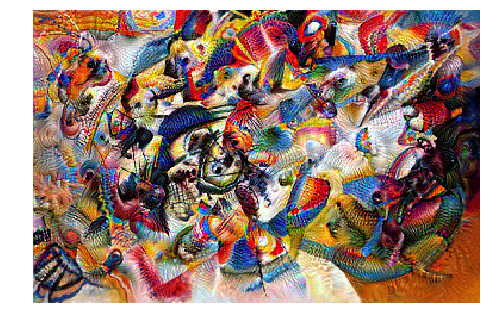

In [0]:
dream_img = run_deep_dream_simple(model=dream_model, img=content_image_i3, steps=800, step_size=0.001)

Above, we only get these little changes applied at a single "scale". Meaning, the visual constructs (think "eyes") are of a single scale, for example 20x20 pixels. We would like to get "eyes" in any scale, even much bigger.

The following loop will change the scale of the image itself (a.k.a octave) and apply the same algorithm as above.

The result is "smoother" and find bigger things. For example I can definitely see a "bird" and a few "dogs".

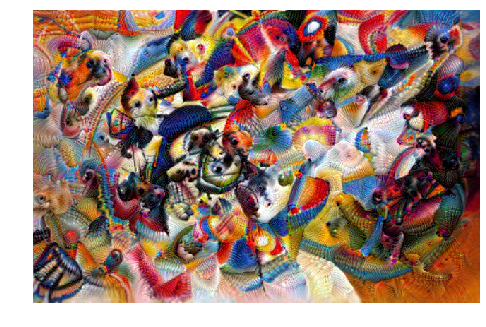

In [0]:
OCTAVE_SCALE = 1.3

img = tf.constant(np.array(content_image_i3))
base_shape = tf.cast(tf.shape(img)[1:-1], tf.float32)
print(base_shape)

for n in range(3):
    new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(model=dream_model, img=img, steps=200, step_size=0.001)

To get an even more hi-res result we utilize Tiling. We split the image to tiles and run the algorithm on each small tile at higher resolution.

The end result is much higer resolution and shows the "puppy slug" effect you must have seen before.

Again below are some extra code cells you'd need to run. Expand them out for details.

In [0]:
def random_roll(img, maxroll):
    # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0],shift[1] 
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled

In [0]:
@tf.function
def get_tiled_gradients(model, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    for x in tf.range(0, img_rolled.shape[0], tile_size):
        for y in tf.range(0, img_rolled.shape[1], tile_size):
            # Calculate the gradients for this tile.
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img_rolled`.
                # `GradientTape` only watches `tf.Variable`s by default.
                tape.watch(img_rolled)

                # Extract a tile out of the image.
                img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                loss = calc_loss(img_tile, model)

                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [0]:
def run_deep_dream_with_octaves(model, img, steps_per_octave=100, step_size=0.01, 
                                num_octaves=3, octave_scale=1.3):
    for octave in range(num_octaves):
        # Scale the image based on the octave
        if octave>0:
            new_size = tf.cast(img.shape[1:3], tf.float32)*octave_scale
            img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(model, img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

            if step % 10 == 0:
                clear_output(wait=True)
                show_n([deprocess(img)])
                print ("Octave {}, Step {}".format(octave, step))

    clear_output(wait=True)
    result = deprocess(img)
    show_n([result])

    return result

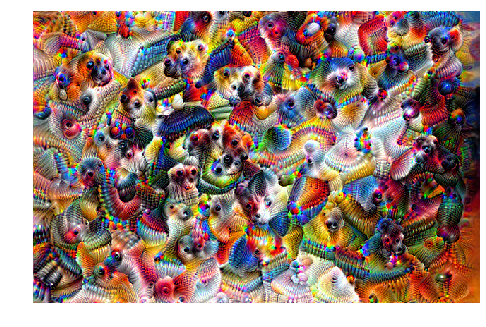

In [0]:
dream_img = run_deep_dream_with_octaves(model=dream_model, img=content_image_i3, step_size=0.01)

## Neural Doodle

Neural doodle is effectively guided style transfer. First we mask the input style image with regions of different "semantic" value, e.g. Grass, Sky, Rock, etc. Then given a new mask we ask the model to complete in the details from the original image.

As per usual, there's going to be some significant code to make this happen. Feel free to explore it.

In [0]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

Like we did before, we select some specific layers (this time from [VGG19](https://arxiv.org/abs/1409.1556)) to guide the transfer. See for "Style" we pick layers from multiple heights, so we get small scale features as well as larger ones:

In [0]:
content_layers = ['block5_conv2'] # content layer
style_layers = ['block%d_conv1'%i for i in [1,2,3,4]] # Style layer of interest

In [0]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers, input_shape):
        super(StyleContentModel, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_style_layers = len(self.style_layers)
        
        # Load our model. Load pretrained VGG, trained on imagenet data
        self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        self.vgg.trainable = False

        # mask model as a series of pooling
        mask_input = tf.keras.layers.Input(shape=input_shape, name='mask_input')
        x = mask_input
        for layer in self.vgg.layers[1:]:
            name = 'mask_%s' % layer.name
            if 'conv' in layer.name:
                x = tf.keras.layers.AveragePooling2D((3, 3), padding='same', strides=(1, 1), name=name)(x)
            elif 'pool' in layer.name:
                x = tf.keras.layers.AveragePooling2D((2, 2), name=name)(x)
        self.mask_model = tf.keras.Model(mask_input, x)
        self.vgg_layers_mask = tf.keras.Model([self.mask_model.input], 
                                              [self.mask_model.get_layer('mask_%s' % name).output for name in self.style_layers])

        self.vgg_layers_style   = tf.keras.Model([self.vgg.input], 
                                                 [self.vgg.get_layer(name).output for name in self.style_layers])
        self.vgg_layers_content = tf.keras.Model([self.vgg.input], 
                                                 [self.vgg.get_layer(name).output for name in self.content_layers])
        

    def call(self, inputs, masks, show_masks=False):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        style_outputs = []
        mask_features = [self.vgg_layers_mask(tf.cast(tf.reshape(m, [1,*m.shape,1]), tf.float32)) for m in masks]
        if show_masks:
            show_n([tf.squeeze(m,-1) for m in mask_features[0]], colorbar=True)
        
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) 
        for m in mask_features:
            outputs_style = self.vgg_layers_style(preprocessed_input)
            outputs_style = [outputs_style[i] * m[i] for i in range(len(m))] # apply mask to image features
            outputs_style = [gram_matrix(outputs_style[i]) / tf.reduce_mean(m[i]) for i in range(len(m))]
            style_dict = {style_name:value for style_name, value in zip(self.style_layers, outputs_style)}
            style_outputs += [style_dict]
            
        content_outputs = self.vgg_layers_content(preprocessed_input)
        if not isinstance(content_outputs, list):
            content_outputs = [content_outputs]
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

        return {'content':content_dict, 'style':style_outputs}

In [0]:
def kmeans(xs, k):
    assert xs.ndim == 2
    try:
        from sklearn.cluster import k_means
        _, labels, _ = k_means(xs.astype('float64'), k)
    except ImportError:
        from scipy.cluster.vq import kmeans2
        _, labels = kmeans2(xs, k, missing='raise')
    return labels

def load_mask_labels(style_mask_path, target_mask_path, num_labels, show_masks=False):
    '''Load both target and style masks.
    A mask image (nr x nc) with m labels/colors will be loaded as an array
    '''
    target_mask_img = load_image(target_mask_path)
    style_mask_img = load_image(style_mask_path)
    if show_masks:
        show_n([style_mask_img, target_mask_img], ['Input mask', 'Target mask'])
        
    mask_vecs = np.vstack([tf.reshape(style_mask_img, (-1, 3)), tf.reshape(target_mask_img, (-1, 3))])

    img_nrows, img_ncols = style_mask_img.shape[1:3]
    labels = kmeans(mask_vecs, num_labels)
    style_mask_label = labels[:img_nrows * img_ncols].reshape((img_nrows, img_ncols))
    target_mask_label = labels[img_nrows * img_ncols:].reshape((img_nrows, img_ncols))

    return ([style_mask_label == r for r in range(num_labels)], 
            [target_mask_label == r for r in range(num_labels)])


In [0]:
import os
import glob

files = glob.glob('https://github.com/Nahzuri/Computer-Visions.gi*')
for f in files:
    os.remove(f)

In [19]:
!pip install -q xlrd
!git clone https://github.com/Nahzuri/Computer-Visions.git .

fatal: destination path '.' already exists and is not an empty directory.


In [0]:
# Files from the cloned git repository.
!ls HW0/Assets

ls: cannot access 'HW0/Assets': No such file or directory


In [0]:
im = Image('738px-Haeckel_Discomedusae_98.jpg')

In [0]:
content_image = im

Consider this Max Liebermann painting.

TypeError: ignored

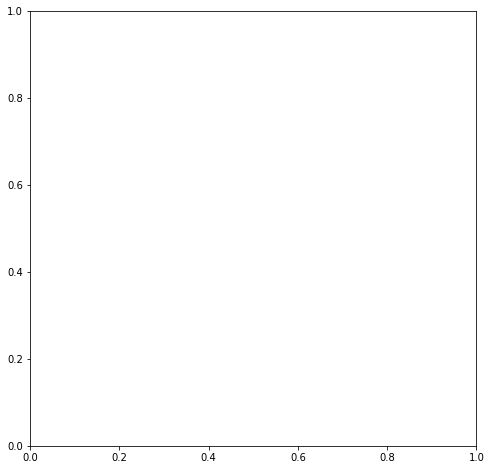

In [0]:
content_image = im
show_n([content_image],['Input'])

We can create a masking of the painting with several regions. And then doodle another mask:

8192/5035 [================================================] - 0s 0us/step


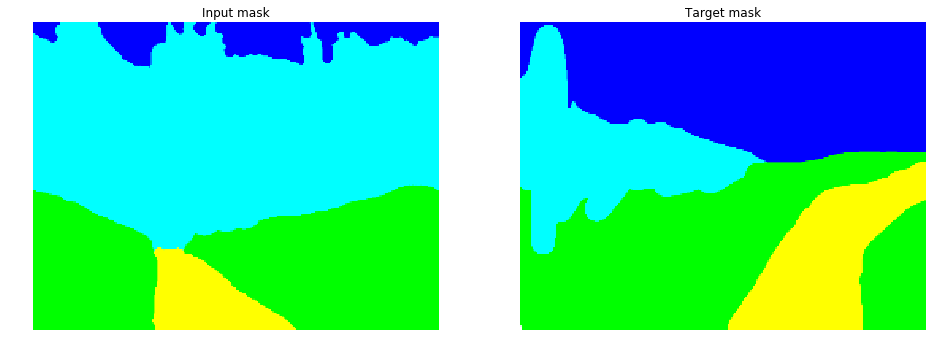

In [0]:
style_masks, target_masks = load_mask_labels("https://storage.googleapis.com/mas-s68-f19/Max_Liebermann_Der_Nutzgarten_in_Wannsee_nach_Westen_1922-mask.png", 
                                             "https://storage.googleapis.com/mas-s68-f19/doodle-mask.png", 
                                             num_labels=4, show_masks=True)

In [0]:
model = StyleContentModel(style_layers, content_layers, [*target_masks[0].shape, 1])

80142336/80134624 [==============================] - 3s 0us/step


This shows us the way the visual features are going to be masked according the regions:

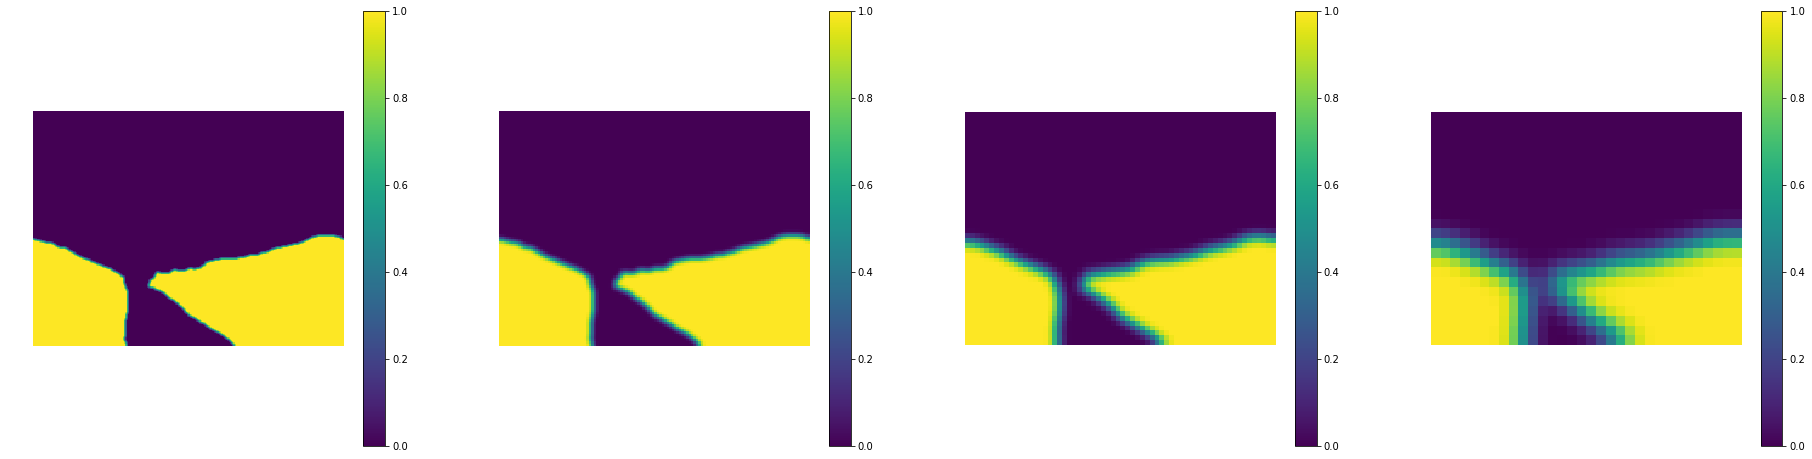

In [0]:
sources = model(content_image, style_masks, show_masks=True)

In [0]:
source_content, source_style = sources['content'], sources['style']

num_style_layers = float(len(style_layers))
num_content_layers = float(len(content_layers))

style_weight=1.
content_weight=0.1
tv_weight=100.

The Loss Function reveals that we are simply looking at the mean of squared distance (MSD) between our target and source image features:

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    loss = 0
    for i in range(len(style_outputs)):
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[i][name]-source_style[i][name])**2) 
                               for name in style_outputs[i].keys()])
        loss += style_loss * style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-source_content[name])**2) 
                     for name in content_outputs.keys()])
    
    return loss + content_loss * content_weight / num_content_layers

In [0]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
@tf.function()
def train_step(image, masks):
    with tf.GradientTape() as tape:
        outputs = model(image, masks)
        loss = style_content_loss(outputs) + tv_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Below we set the input to the algorithm. 

Experiment with starting with a totally random image vs. starting from the original image. (Uncomment one line or the other)

In [0]:
# image = tf.Variable(tf.random.uniform([1, *target_masks[0].shape, 3]))
image = tf.Variable(tf.identity(content_image))

The execution loop simply applies the gradients imposed by the loss function:

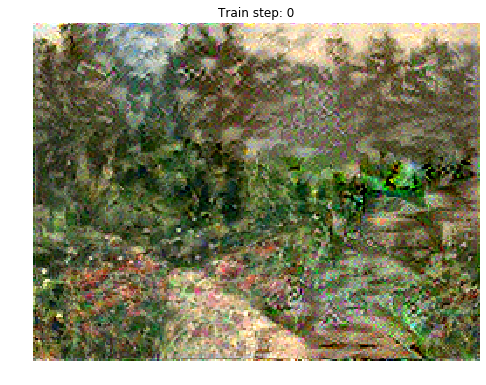

KeyboardInterrupt: ignored

In [0]:
start = time.time()

epochs = 10
steps_per_epoch = 100

clear_output(wait=True)
show_n([image.read_value()],["Train step: {}".format(0)])

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, target_masks)
        print(".", end='')
    clear_output(wait=True)
    show_n([image.read_value()],["Train step: {}".format(step)])

end = time.time()
print("Total time: {:.1f}".format(end-start))

The results can be quite artistic! Although it's no Liebermann.. 😀

You should try your own doodles! Just change the doodle input image.